In [24]:
import os, cv2
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import pandas as pd
from PIL import Image
from patchify import patchify
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import backend as K
from keras.models import Model , load_model
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras import layers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Data Pre processing

In [3]:
root_folder = './data/SemanticSegmentationDataset'

In [4]:
# cut images into 256x256 pieces
img_patch_size = 256
# scale each variable to the range of 0-1
scaler = MinMaxScaler()

In [5]:
img_dataset =[]

for path , subdirs, files in os.walk(root_folder):
    
    # name of each direcory
    dir_name = path.split(os.path.sep)[-1]
    
    if dir_name== 'images':
        print(path)
        
        # list of images in each 'image' directory
        images_lst = os.listdir(path)
        images_lst.sort()
        
        for i , img in enumerate(images_lst):
            if img.endswith('.jpg'): 
                print('-------------------\n' ,img)
                
                #read images as RGB
                image = cv2.imread(path+ '/' + img , 1)
                print(image.shape)
                
                # images are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (image.shape[1] // img_patch_size) * img_patch_size
                sizeY = (image.shape[0] // img_patch_size) * img_patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,sizeX,sizeY))
                print(image)
                
                # convert images into numpy array
                image = np.array(image)

                # cut up images into 256x256 pieces
                patched_imgs = patchify(image , (img_patch_size,img_patch_size,3) , step= img_patch_size)
                print(patched_imgs.shape)
                
                for i in range(patched_imgs.shape[0]):
                    for j in range(patched_imgs.shape[1]):
                        single_patch_img = patched_imgs[i,j,:,:]

                        # normalize images via MinMaxScaler => value between 0 and 1
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        
                        # add all patched images to a list
                        img_dataset.append(single_patch_img)

./data/SemanticSegmentationDataset\Tile 1\images
-------------------
 image_part_001.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD48510>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_002.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD48510>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_003.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD48510>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_004.jpg
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BC75C90>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_005.jpg
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BC75C90>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_006.jpg
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD49590>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_007.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD4

In [6]:
msk_dataset = [] 

for path, subdirs, files in os.walk(root_folder):

    # name of each direcory
    dirname = path.split(os.path.sep)[-1]
    
    if dirname == 'masks':
        print(path)
        
        # list of masks in each 'mask' directory
        masks_lst = os.listdir(path)
        masks_lst.sort()
        
        
        for i, msk in enumerate(masks_lst):  
            if msk.endswith(".png"):
                print('-------------------\n' ,msk)
               
                #Read each mask as RGB
                mask = cv2.imread(path+"/"+msk, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                print(mask.shape)
                
                # masks are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (mask.shape[1]//img_patch_size)*img_patch_size 
                sizeY = (mask.shape[0]//img_patch_size)*img_patch_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, sizeX, sizeY)) 
                print(mask)
                
                # convert masks into numpy array
                mask = np.array(mask)             
       
                # cut up masks into 256x256 pieces
                patched_masks = patchify(mask , (img_patch_size,img_patch_size,3) , step= img_patch_size)
                print(patched_masks.shape)
        
                for i in range(patched_masks.shape[0]):
                    for j in range(patched_masks.shape[1]):
                        
                        single_patch_mask = patched_masks[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]  
                        
                        # add all patched masks to a list
                        msk_dataset.append(single_patch_mask) 

./data/SemanticSegmentationDataset\Tile 1\masks
-------------------
 image_part_001.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD37AD0>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_002.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD37750>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_003.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD37AD0>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_004.png
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD37750>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_005.png
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD37750>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_006.png
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD37750>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_007.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2116BD37

In [7]:
img_dataset = np.array(img_dataset)
msk_dataset =  np.array(msk_dataset)

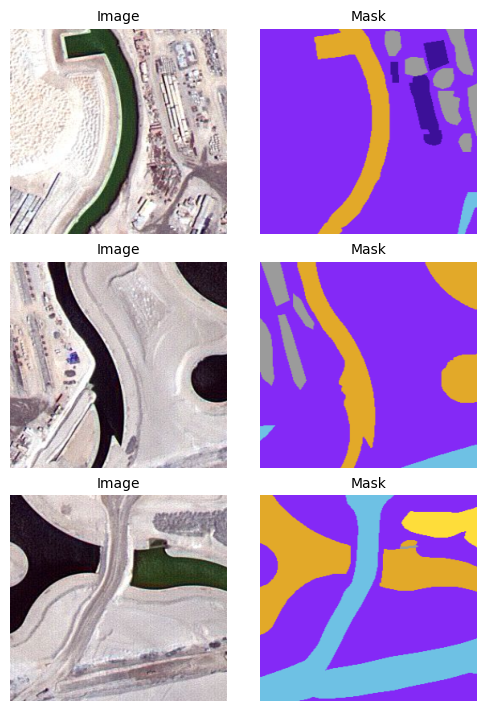

In [8]:
# Visualise patched images & their corresponding masks
count = 0
i = 0
fig, axs = plt.subplots(3, 2, figsize=(5, 7), constrained_layout=True)

for mask in msk_dataset:
    if (mask.all()):
        # read images
        axs[count][0].imshow(cv2.resize(img_dataset[i], (270,256)))
        axs[count][0].set_title('Image', fontdict = {'fontsize':10})
        axs[count][0].axis(False)
        
        # read masks
        axs[count][1].imshow(cv2.resize(msk_dataset[i], (270,256)))
        axs[count][1].set_title('Mask' , fontdict = {'fontsize':10})
        axs[count][1].axis(False)

        count +=1
    i += 1
    if (count==3):
        break
        
plt.show()

In [9]:
# Convert HEX labels to RGB array
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))
print('Building :' , Building)

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))
print('Land :' , Land)

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) 
print('Road :' , Road)

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))
print('Vegetation :' , Vegetation)

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) 
print('Water :' , Water)

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))
print('Unlabeled :' , Unlabeled)


Building : [ 60  16 152]
Land : [132  41 246]
Road : [110 193 228]
Vegetation : [254 221  58]
Water : [226 169  41]
Unlabeled : [155 155 155]


In [10]:
def rgb_to_2D_label(msk_dt):

    # create a new array of given shape and type of each row of mask dataset, filled with zeros
    label_seg = np.zeros(msk_dt.shape, dtype = np.uint8)
    
    label_seg [np.all(msk_dt == Building,axis=-1)] = 0
    label_seg [np.all(msk_dt==Land,axis=-1)] = 1
    label_seg [np.all(msk_dt==Road,axis=-1)] = 2
    label_seg [np.all(msk_dt==Vegetation,axis=-1)] = 3
    label_seg [np.all(msk_dt==Water,axis=-1)] = 4
    label_seg [np.all(msk_dt==Unlabeled,axis=-1)] = 5
    
    # just take the first channel
    label_seg = label_seg[:,:,0]  
    
    return label_seg

In [11]:
labels = []
for i in range(msk_dataset.shape[0]):
    label = rgb_to_2D_label(msk_dataset[i])
    labels.append(label)

In [12]:
labels = np.array(labels) 
print(labels.shape)

(1305, 256, 256)


In [13]:
labels = np.expand_dims(labels, axis=3)
labels.shape

(1305, 256, 256, 1)

In [14]:
# one-hot-ecoding
print("all labels : ", np.unique(labels))
n_classes = len(np.unique(labels)) #6
labels_cat = to_categorical(labels, num_classes=n_classes)

all labels :  [0 1 2 3 4 5]


In [15]:
# split data into training & testing dataset
X_train, X_test, y_train, y_test = train_test_split(img_dataset, labels_cat, test_size = 0.20, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1044, 256, 256, 3)
(261, 256, 256, 3)
(1044, 256, 256, 6)
(261, 256, 256, 6)


UNETR Model

In [20]:
# image config
img_size = 256 # X_train.shape[1] or X_train.shape[2]
num_channels = 3 # X_train.shape[3]
input_shape = (img_size, img_size, num_channels)
num_classes = 2

# hyperparameters configuration
patch_size = 16
num_patches = (img_size // patch_size) * (img_size // patch_size)
hidden_dim = 768 # the size of the feature vectors or embeddings for representing the input data
num_heads = 8  # Number of attention heads in the multi-head attention layer
transformer_layers = 12 # Number of transformer blocks
mlp_dim = 3072  # Size of the dense layers of the final classifier
dropout_rate= 0.1
flat_patches_shape = (num_patches, patch_size*patch_size*num_channels)

In [21]:
def mlp(x, mlp_dim, hidden_dim, dropout_rate):
    x = layers.Dense(mlp_dim, activation="gelu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(hidden_dim, activation="gelu")(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

In [23]:
# UNETR model => Transformer ecoder (as backbone to leran the global contexual representation) & CNN-based decoder (to upsample the global representation and generate the final segmentation mask)
# encoder
def vit_encoder(x, num_heads, hidden_dim):
    # Layer normalization 1
    x1 = layers.LayerNormalization()(x)
    # multi-head attention layer
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim, dropout=0.1)(x1, x1)
    # Skip connection 1
    x2 = layers.Add()([attention_output, x])
    # Layer normalization 2
    x3 = layers.LayerNormalization()(x2)
    # MLP
    x3 = mlp(x3, mlp_dim, hidden_dim, dropout_rate)
    x = layers.Add()([x3, x2])
    return x

# decoder
def conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def deconv_block(x, num_filters):
    x = layers.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

In [ ]:
def UNETR_2D(cf):
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape) ## (None, 256, 768)

    # Patch + Position Embeddings
    patch_embed = L.Dense(cf["hidden_dim"])(inputs) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    # Transformer Encoder
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    # CNN Decoder
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)
    z3 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z3)
    z6 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z6)
    z9 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z9)
    z12 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z12)

    ## Decoder 1
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)
    x = L.Concatenate()([x, s])

    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs)

In [18]:
# metrics
def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)
    return ((2* And + 1.0) / (K.sum(y_truef) + K.sum(y_predf) + 1.0)) 

metrics=['accuracy', dice_coef]

In [ ]:
model = multi_unet()
model.compile(optimizer = 'adam', loss = total_loss , metrics = ['accuracy', dice_coef])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
history2 = model2.fit(X_train, y_train, batch_size = 32, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = [callback, reduce_lr], shuffle=True)

# evalute model
loss2,acc2,dice_loss2= model2.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc2)

<AxesSubplot: >

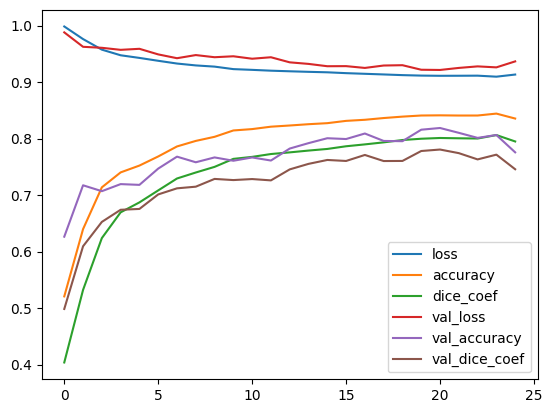

In [59]:
pd.DataFrame(history1.history).plot()

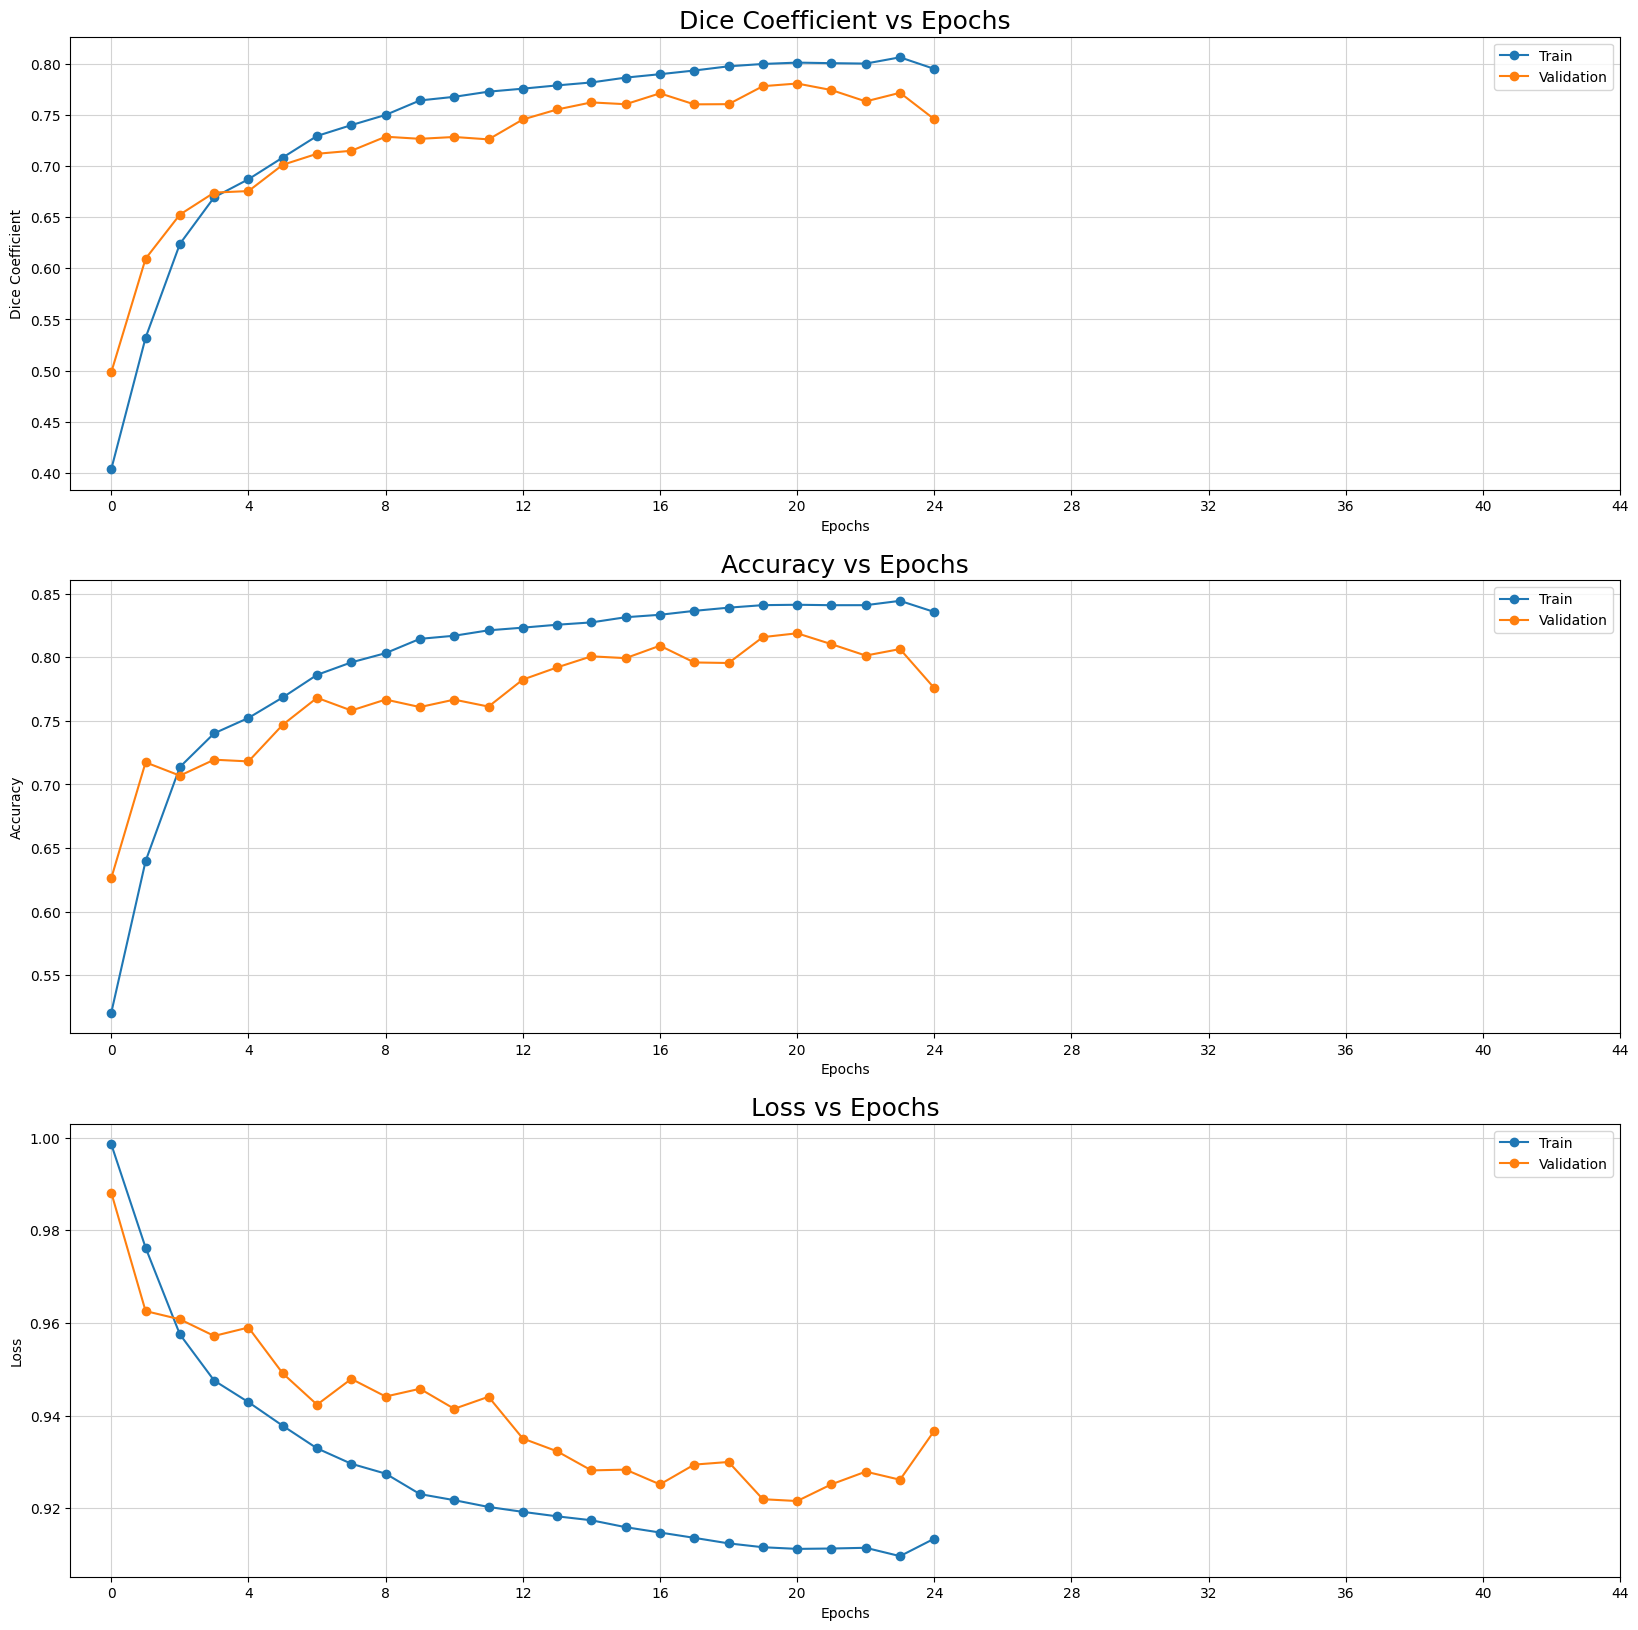

In [75]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss']): 
    ax[i].plot(history1.history[met], 'o-')
    ax[i].plot(history1.history['val_' + met], 'o-')
    ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")    



In [67]:
model_1.save("./models/Multiclass_Unet_Model.h5")

In [91]:
y_pred=model_1.predict(X_test)

9/9 [==============================] - 9s 959ms/step


In [118]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3) 

1/1 [==============================] - 0s 49ms/step


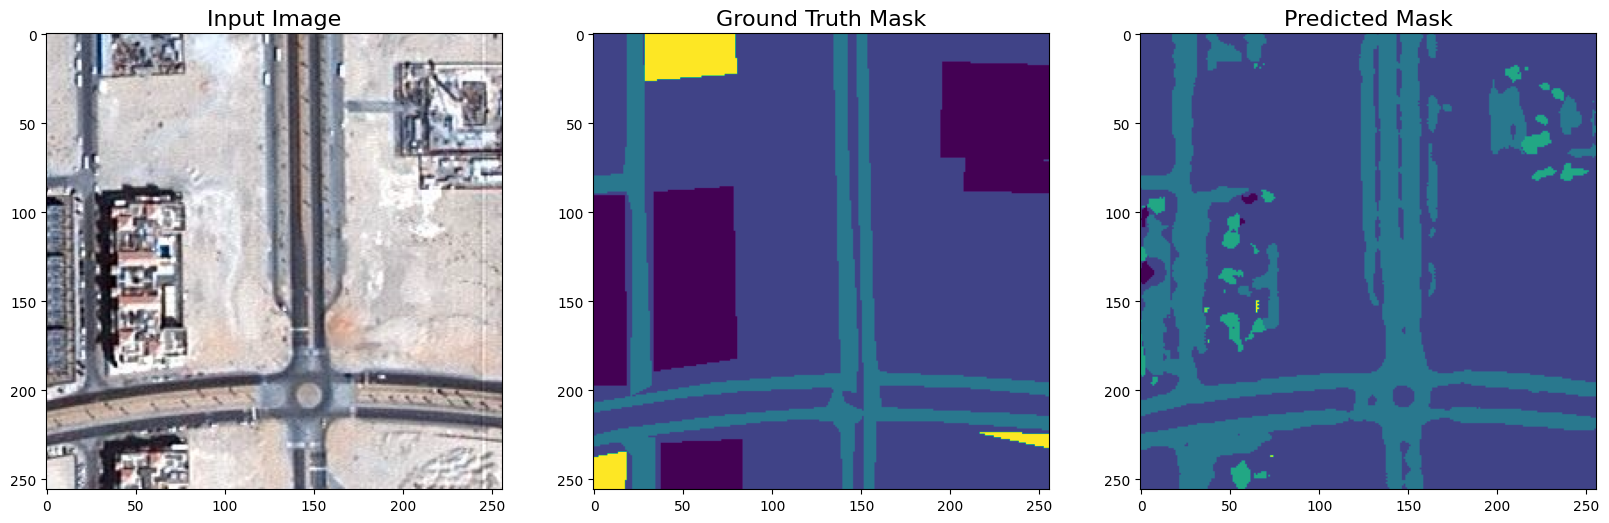

1/1 [==============================] - 0s 49ms/step


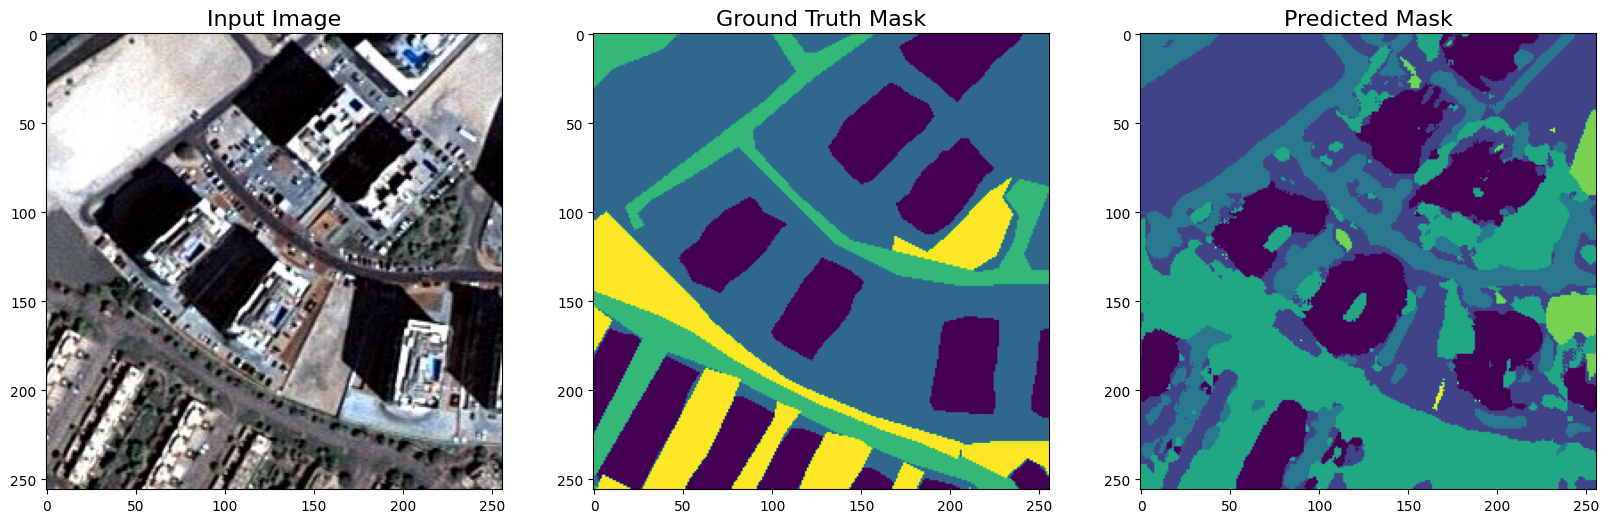

1/1 [==============================] - 0s 50ms/step


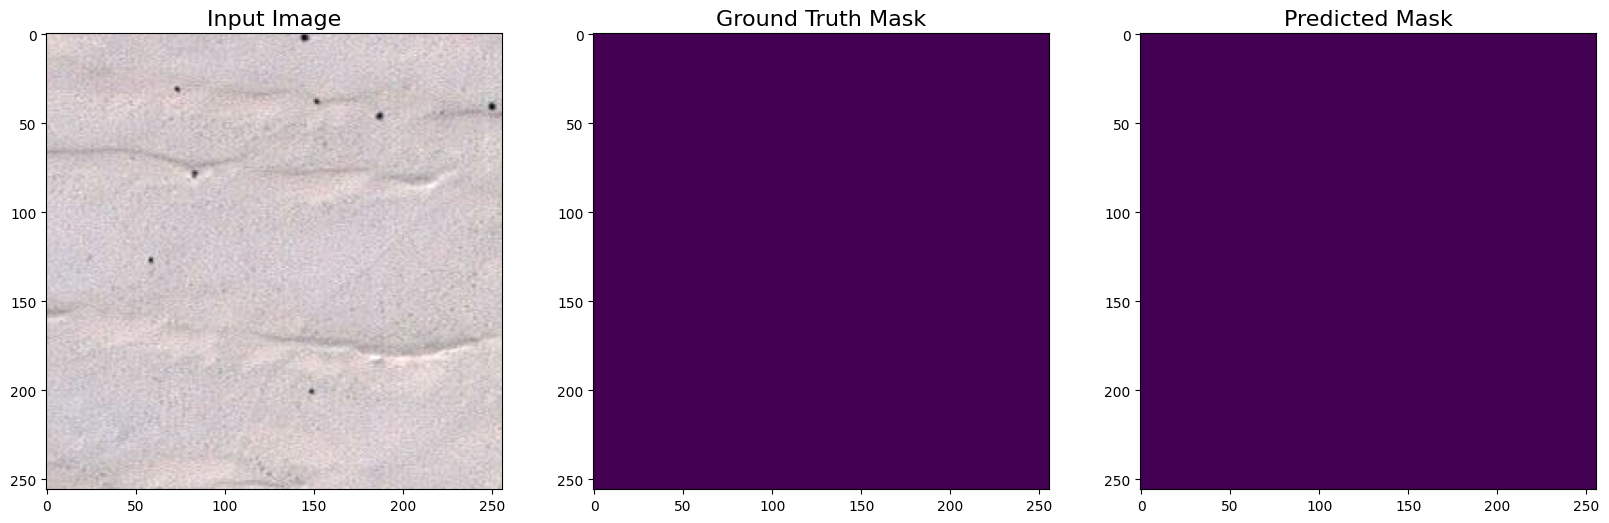

1/1 [==============================] - 0s 48ms/step


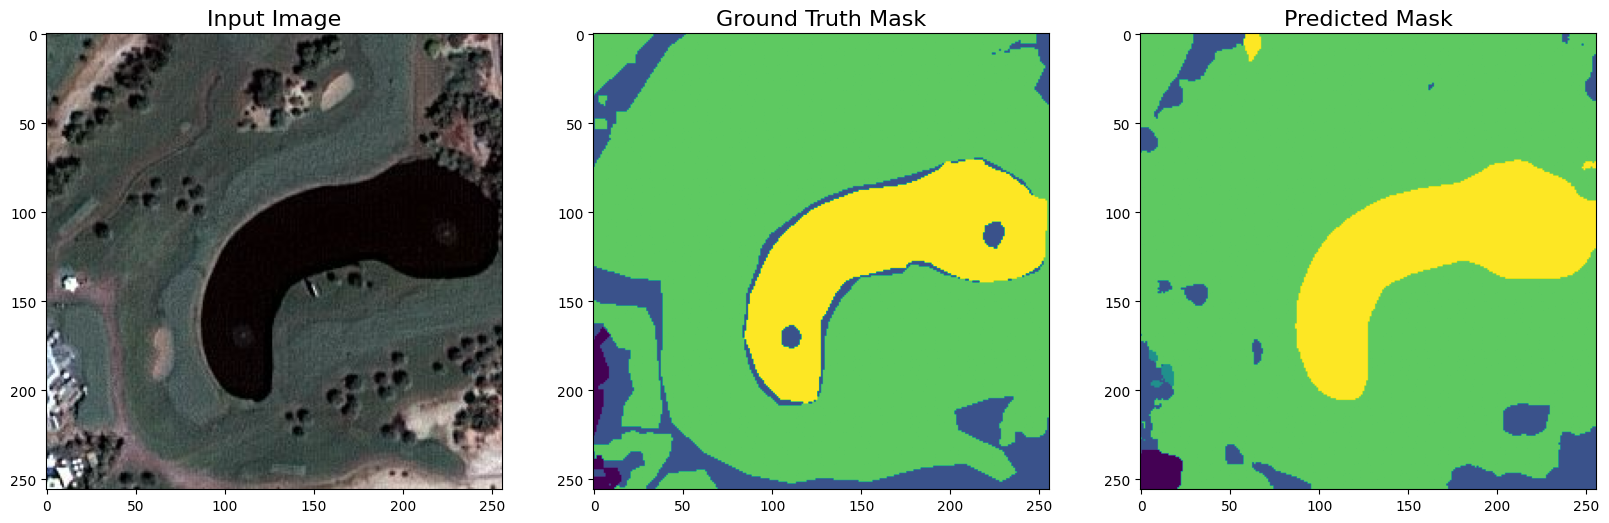

In [115]:
for i in range(4):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(X_test[i])
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(y_test_argmax[i])

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(np.argmax(model_1.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
        
    plt.show()

In [108]:
satellite_model = load_model('./models/Multiclass_Unet_Model.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 
                                          'dice_coef': dice_coef}))

In [109]:
test_image = Image.open('test.jpg')
test_image = test_image.resize((256,256))
test_image = np.array(test_image)
test_image = np.expand_dims(test_image, 0)
test_image.shape

(1, 256, 256, 3)

In [110]:
test_prediction = satellite_model.predict(test_image)
test_prediction.shape

1/1 [==============================] - 0s 196ms/step


(1, 256, 256, 6)

In [111]:
test_predicted_image = np.argmax(test_prediction, axis=3)
test_predicted_image = test_predicted_image[0,:,:]
test_predicted_image

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

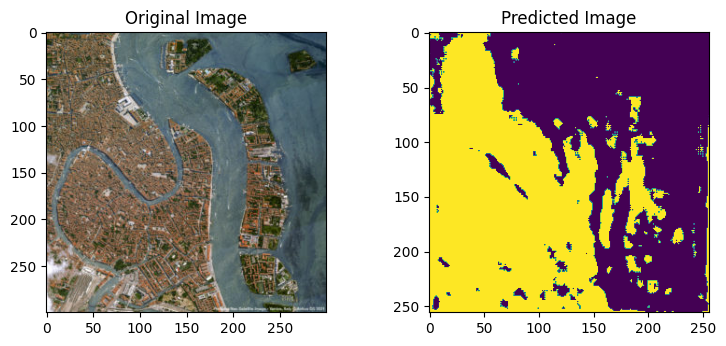

In [112]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('test.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(test_predicted_image)